In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [7]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

100% 1.17G/1.17G [00:07<00:00, 159MB/s]
100% 1.17G/1.17G [00:07<00:00, 166MB/s]


In [8]:
import zipfile
zf = "/content/labeled-chest-xray-images.zip"
target_dir = "/content/dataset/cnn/labeled-chest-xray-images"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [10]:
train_path = '/content/dataset/cnn/labeled-chest-xray-images/chest_xray/train'
test_path = '/content/dataset/cnn/labeled-chest-xray-images/chest_xray/test'

In [16]:
batch_size = 48

img_height = 150
img_width = 150

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.4,shear_range=0.3,vertical_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [18]:
train = image_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',color_mode='grayscale',batch_size=batch_size)
test = test_data_gen.flow_from_directory(test_path,target_size=(img_height,img_width),shuffle=False,class_mode='binary',color_mode='grayscale',batch_size=batch_size)

decoder_input = test_data_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',color_mode='grayscale',batch_size=batch_size,shuffle=False)
decoder_output = test_data_gen.flow_from_directory(train_path,target_size=(40,40),class_mode='binary',color_mode='grayscale',batch_size=batch_size,shuffle=False)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [19]:
import tensorflow as tf

import os
import keras
from keras.models import Sequential, Model
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, BatchNormalization, Input, SeparableConv2D, UpSampling2D

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tqdm.notebook import tqdm

from keras.optimizers import SGD

In [21]:
#Creating the decoder's data
X = []
Y = []
for _ in tqdm(range(109)):
    X += list(decoder_input.next()[0])
    Y += list(decoder_output.next()[0])
X = np.array(X)
Y = np.array(Y)

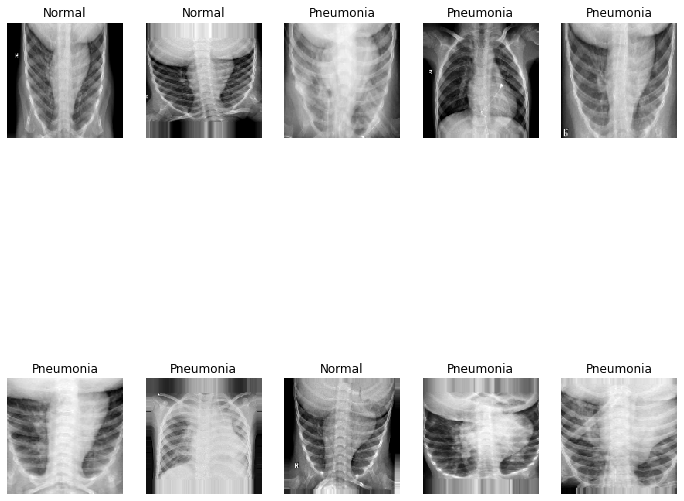

In [22]:
plt.figure(figsize=(12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch,Y_batch in train:
    image = X_batch[0]
    dic = {0:'Normal',1:'Pneumonia'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')

    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
    break

    plt.tight_layout()
    plt.show()

In [23]:
def SeparableConvBlock(filter_n,kernel_shape,pool_size,init,input_shape,name=None):
    
    input_layer = Input(input_shape)
    
    model = SeparableConv2D(filter_n,kernel_shape,input_shape=(img_width,img_height,1),kernel_initializer=init)(input_layer)
    model = BatchNormalization()(model)
    model = keras.layers.ELU()(model)

    model = SeparableConv2D(filter_n,kernel_shape,kernel_initializer=init)(model)
    model = BatchNormalization()(model)
    model = keras.layers.ELU()(model)


    model = MaxPooling2D(pool_size=pool_size)(model)
    
    return Model(input_layer,model,name=name),model.shape

In [24]:
input_layer = Input(shape=(img_height,img_width,1))

#Encoder

layer,shape = SeparableConvBlock(32,(3,3),(2,2),'glorot_uniform',(img_width,img_height,1),"SPB1")
enc = layer(input_layer)
layer,shape = SeparableConvBlock(64,(3,3),(2,2),'glorot_uniform',(shape[1:]),"SPB2")
enc = layer(enc)
layer,shape = SeparableConvBlock(128,(3,3),(2,2),'glorot_uniform',(shape[1:]),"SPB3")
enc = layer(enc)
layer,shape = SeparableConvBlock(256,(3,3),(2,2),'glorot_uniform',(shape[1:]),"SPB4")
enc = layer(enc)

Encoder = Model(input_layer,enc)

#Decoder

decoder = SeparableConv2D(128, (3, 3), activation='sigmoid', padding='same')(enc)
decoder = BatchNormalization()(decoder)
decoder = SeparableConv2D(128, (3, 3), activation='sigmoid', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = UpSampling2D((2,2))(decoder)

decoder = SeparableConv2D(64, (3, 3), activation='sigmoid', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = SeparableConv2D(64, (3, 3), activation='sigmoid', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = UpSampling2D((2,2))(decoder)

decoder = SeparableConv2D(32, (3, 3), activation='sigmoid', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = SeparableConv2D(32, (3, 3), activation='sigmoid', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = UpSampling2D((2,2))(decoder)


decoder = SeparableConv2D(1, (3, 3), activation='sigmoid', padding='same')(decoder)

Decoder = Model(input_layer,decoder)
                
                
#Classifier
flatten = Flatten()(enc)
dense = Dense(128,activation='relu')(flatten)
dense = BatchNormalization()(dense)
dense = Dense(64,activation='relu')(dense)
dense = BatchNormalization()(dense)
dense = Dropout(0.5)(dense)
dense = Dense(1,activation='sigmoid')(dense)

Classifier = Model(input_layer,dense)

In [25]:
Decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
SPB1 (Functional)            (None, 73, 73, 32)        1673      
_________________________________________________________________
SPB2 (Functional)            (None, 34, 34, 64)        7648      
_________________________________________________________________
SPB3 (Functional)            (None, 15, 15, 128)       27584     
_________________________________________________________________
SPB4 (Functional)            (None, 5, 5, 256)         104320    
_________________________________________________________________
separable_conv2d_8 (Separabl (None, 5, 5, 128)         35200     
_________________________________________________________________
batch_normalization_8 (Batch (None, 5, 5, 128)         512 

In [26]:
Decoder.compile(loss='mean_squared_error', optimizer = SGD())

In [27]:
Decoder.fit(X,Y,batch_size=batch_size,epochs=30)

Epoch 1/30
109/109 [==============================] - 63s 261ms/step - loss: 0.0461
Epoch 2/30
109/109 [==============================] - 28s 260ms/step - loss: 0.0302
Epoch 3/30
109/109 [==============================] - 29s 265ms/step - loss: 0.0259
Epoch 4/30
109/109 [==============================] - 29s 269ms/step - loss: 0.0233
Epoch 5/30
109/109 [==============================] - 30s 279ms/step - loss: 0.0213
Epoch 6/30
109/109 [==============================] - 30s 274ms/step - loss: 0.0203
Epoch 7/30
109/109 [==============================] - 30s 275ms/step - loss: 0.0193
Epoch 8/30
109/109 [==============================] - 30s 274ms/step - loss: 0.0187
Epoch 9/30
109/109 [==============================] - 30s 277ms/step - loss: 0.0182
Epoch 10/30
109/109 [==============================] - 30s 277ms/step - loss: 0.0176
Epoch 11/30
109/109 [==============================] - 30s 274ms/step - loss: 0.0173
Epoch 12/30
109/109 [==============================] - 30s 274ms/step - lo

In [28]:
predictions = Decoder.predict(X)

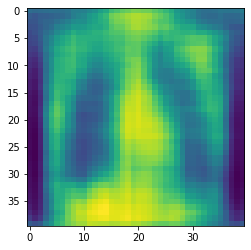

In [29]:
plt.imshow((tf.squeeze(predictions[0])))
plt.show()

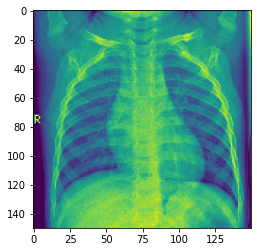

In [30]:
plt.imshow((tf.squeeze(X[0])))
plt.show()

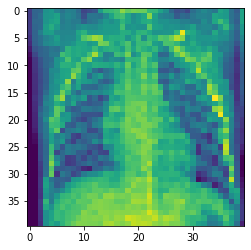

In [31]:
plt.imshow((tf.squeeze(Y[0])))
plt.show()

In [32]:
Classifier.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
SPB1 (Functional)            (None, 73, 73, 32)        1673      
_________________________________________________________________
SPB2 (Functional)            (None, 34, 34, 64)        7648      
_________________________________________________________________
SPB3 (Functional)            (None, 15, 15, 128)       27584     
_________________________________________________________________
SPB4 (Functional)            (None, 5, 5, 256)         104320    
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               8193

In [33]:
Classifier.compile(optimizer=SGD(),loss='binary_crossentropy',metrics=['accuracy'])

In [34]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes),train.classes)
cw = dict(zip(np.unique(train.classes),weights))
print(cw)

{0: 1.939214232765011, 1: 0.6737058975019315}


In [36]:
Classifier.fit(train,epochs=25,class_weight=cw,batch_size=512)

Epoch 1/25
109/109 [==============================] - 61s 546ms/step - loss: 0.5556 - accuracy: 0.7124
Epoch 2/25
109/109 [==============================] - 59s 542ms/step - loss: 0.3692 - accuracy: 0.8255
Epoch 3/25
109/109 [==============================] - 58s 530ms/step - loss: 0.3213 - accuracy: 0.8636
Epoch 4/25
109/109 [==============================] - 58s 533ms/step - loss: 0.2952 - accuracy: 0.8741
Epoch 5/25
109/109 [==============================] - 58s 535ms/step - loss: 0.2760 - accuracy: 0.8880
Epoch 6/25
109/109 [==============================] - 58s 533ms/step - loss: 0.2703 - accuracy: 0.8907
Epoch 7/25
109/109 [==============================] - 58s 531ms/step - loss: 0.2587 - accuracy: 0.8991
Epoch 8/25
109/109 [==============================] - 58s 529ms/step - loss: 0.2387 - accuracy: 0.9123
Epoch 9/25
109/109 [==============================] - 58s 535ms/step - loss: 0.2312 - accuracy: 0.9158
Epoch 10/25
109/109 [==============================] - 58s 535ms/step - l

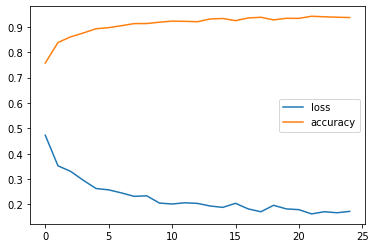

In [37]:
pd.DataFrame(Classifier.history.history).plot()

In [38]:
test_accu = Classifier.evaluate(test)
print('The testing accuracy is - ',test_accu[1]*100,'%')

13/13 [==============================] - 5s 351ms/step - loss: 0.2261 - accuracy: 0.9103
The testing accuracy is -  91.02563858032227 %


In [39]:
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score, log_loss

In [40]:
y_bar = np.round(Classifier.predict(test)).reshape(-1)
y_act = test.labels

In [41]:
##accuracy
print("Accuracy: ",accuracy_score(y_bar,y_act))
##Roc_Auc Score
print("ROC-AUC score: ",roc_auc_score(y_bar,y_act))
##F1-Score Score
print("F1 score: ",f1_score(y_bar,y_act))
##Log Loss Score
print("Log Loss: ",log_loss(y_bar,y_act))

Accuracy:  0.9102564102564102
ROC-AUC score:  0.900690521029504
F1 score:  0.924731182795699
Log Loss:  3.0996927237128005


In [42]:
Classifier.save('custom_cnn.h5')